In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load feature-engineered data
df = pd.read_csv("../data/processed/ev_features_v1.csv", parse_dates=["timestamp"], index_col="timestamp")

# Define target and features
target = "num_sessions"
features = [col for col in df.columns if col != target]

# Time-based split: last 7 days for testing
split_date = df.index.max() - pd.Timedelta(days=7)
train = df[df.index <= split_date]
test = df[df.index > split_date]

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")
print(f"Train dates: {train.index.min()} to {train.index.max()}")
print(f"Test dates: {test.index.min()} to {test.index.max()}")

# Separate X and y
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

Train size: 553
Test size: 168
Train dates: 2025-11-09 01:00:00 to 2025-12-02 01:00:00
Test dates: 2025-12-02 02:00:00 to 2025-12-09 01:00:00


In [3]:
# Check categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)

# One-hot encoding
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Ensure both train and test have same columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

print(f"Train shape after encoding: {X_train_encoded.shape}")
print(f"Test shape after encoding: {X_test_encoded.shape}")

Categorical columns: ['weather_condition']
Train shape after encoding: (553, 12)
Test shape after encoding: (168, 12)


C:\Users\Asus\AppData\Local\Temp\ipykernel_2548\3698860021.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()


In [4]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# XGBoost model training
model_xgb = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)

# XGBoost model training
model_xgb.fit(X_train_encoded, y_train)

# Predict on test set
y_pred_xgb = model_xgb.predict(X_test_encoded)

# Calculate metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )




print("XGBoost Results:")
print(f"MAE: {mae_xgb:.3f}")
print(f"RMSE: {rmse_xgb:.3f}")
print("SMAPE:", smape(y_test.values, y_pred_xgb))

XGBoost Results:
MAE: 0.781
RMSE: 0.960
SMAPE: 125.07095895116474


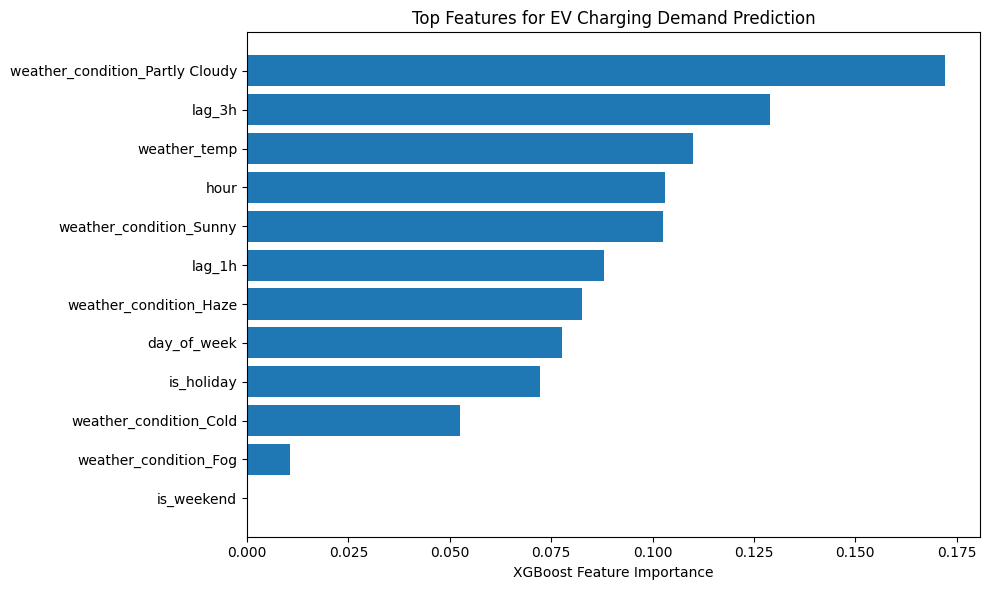

In [5]:
import matplotlib.pyplot as plt

# Feature importance
importances = model_xgb.feature_importances_
feature_names = X_train_encoded.columns

# Sort
sorted_idx = importances.argsort()
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("XGBoost Feature Importance")
plt.title("Top Features for EV Charging Demand Prediction")
plt.tight_layout()
plt.show()

In [6]:
# Step 1: Prepare base future dataframe
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=168, freq='h')
future_df = pd.DataFrame(index=future_dates)

# Step 2: Add time features
future_df['hour'] = future_df.index.hour
future_df['day_of_week'] = future_df.index.dayofweek
future_df['is_weekend'] = future_df['day_of_week'].isin([5, 6]).astype(int)
future_df['is_holiday'] = 0  # holiday calendar available ho toh update karna
future_df['weather_temp'] = df['weather_temp'].mean()  # ya real weather forecast
future_df['weather_condition'] = 'Clear'  # default

# Step 3: One-hot encode weather_condition
future_encoded = pd.get_dummies(future_df, columns=['weather_condition'], drop_first=True)

# Step 4: Ensure columns match training data
future_encoded = future_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Convert lag columns to float
future_encoded['lag_1h'] = future_encoded['lag_1h'].astype(float)
future_encoded['lag_3h'] = future_encoded['lag_3h'].astype(float)

# Step 5: Recursive forecasting for lag features
predictions = []
for i in range(len(future_encoded)):
    if i == 0:
        # First prediction: use last known values from historical data
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_1h')] = df['num_sessions'].iloc[-1]
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_3h')] = df['num_sessions'].iloc[-3] if len(df) >= 3 else 0
    elif i == 1:
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_1h')] = predictions[0]
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_3h')] = df['num_sessions'].iloc[-2]
    elif i == 2:
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_1h')] = predictions[1]
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_3h')] = df['num_sessions'].iloc[-1]
    else:
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_1h')] = predictions[i-1]
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_3h')] = predictions[i-3]
    
    # Predict this hour
    pred = model_xgb.predict(future_encoded.iloc[[i]])[0]
    predictions.append(pred)

# Add to dataframe
future_df['predicted_sessions'] = predictions

print(future_df[['predicted_sessions']].head(10))

                     predicted_sessions
2025-12-09 02:00:00            0.762858
2025-12-09 03:00:00            0.504555
2025-12-09 04:00:00            0.504555
2025-12-09 05:00:00            0.594197
2025-12-09 06:00:00            0.594197
2025-12-09 07:00:00            0.661769
2025-12-09 08:00:00            0.657973
2025-12-09 09:00:00            0.552377
2025-12-09 10:00:00            0.461068
2025-12-09 11:00:00            0.619652


In [7]:
# Bootstrap method for confidence interval
n_bootstraps = 100
predictions_boot = np.zeros((len(future_encoded), n_bootstraps))

for i in range(n_bootstraps):
    # Resample training data with replacement
    idx = np.random.choice(len(X_train_encoded), len(X_train_encoded), replace=True)
    X_resampled = X_train_encoded.iloc[idx]
    y_resampled = y_train.iloc[idx]
    
    # Train a new model
    model_boot = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05, random_state=i)
    model_boot.fit(X_resampled, y_resampled)
    
    # Predict future
    predictions_boot[:, i] = model_boot.predict(future_encoded)

# Calculate confidence intervals
lower_bound = np.percentile(predictions_boot, 5, axis=1)
upper_bound = np.percentile(predictions_boot, 95, axis=1)

future_df['pred_lower'] = lower_bound
future_df['pred_upper'] = upper_bound

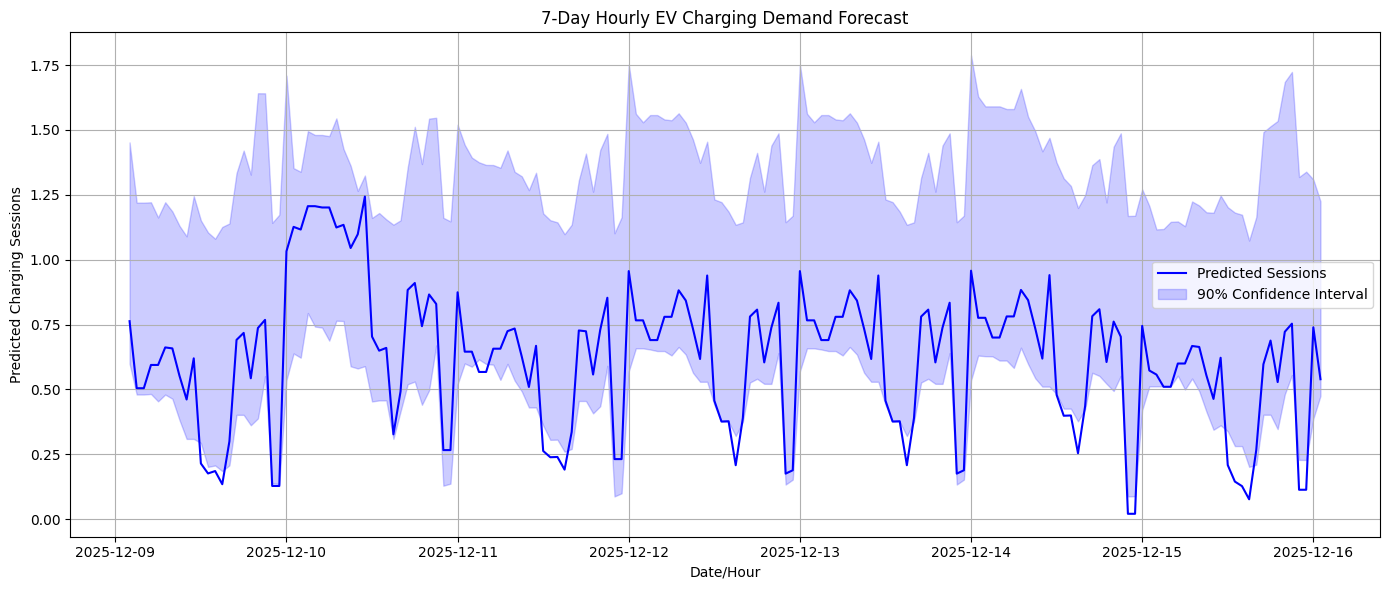

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(future_df.index, future_df['predicted_sessions'], label='Predicted Sessions', color='blue')
plt.fill_between(future_df.index, future_df['pred_lower'], future_df['pred_upper'], color='blue', alpha=0.2, label='90% Confidence Interval')
plt.xlabel('Date/Hour')
plt.ylabel('Predicted Charging Sessions')
plt.title('7-Day Hourly EV Charging Demand Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
import json

# Prepare JSON output
output = {
    "station_id": "STN_DELHI_01",
    "forecast_generated_at": pd.Timestamp.now().isoformat(),
    "forecast_horizon_hours": 168,
    "predictions": []
}

for ts, row in future_df.iterrows():
    output["predictions"].append({
        "timestamp": ts.isoformat(),
        "predicted_sessions": round(row['predicted_sessions'], 2),
        "confidence_lower": round(row['pred_lower'], 2),
        "confidence_upper": round(row['pred_upper'], 2),
    })

# Save to file
with open('../output/7day_forecast.json', 'w') as f:
    json.dump(output, f, indent=2)

print("JSON output saved to '../output/7day_forecast.json'")

JSON output saved to '../output/7day_forecast.json'


In [10]:
import numpy as np

# Bootstrap parameters
n_bootstraps = 100
bootstrap_predictions = np.zeros((len(future_encoded), n_bootstraps))

for b in range(n_bootstraps):
    # Resample training data with replacement
    idx = np.random.choice(len(X_train_encoded), len(X_train_encoded), replace=True)
    X_boot = X_train_encoded.iloc[idx]
    y_boot = y_train.iloc[idx]
    
    # Train a new model
    model_boot = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.05,
        random_state=b,
        n_jobs=-1
    )
    model_boot.fit(X_boot, y_boot)
    
    # Recursive forecasting for this bootstrap model
    preds_boot = []
    future_boot = future_encoded.copy()
    
    for i in range(len(future_boot)):
        if i == 0:
            future_boot.iloc[i, future_boot.columns.get_loc('lag_1h')] = float(df['num_sessions'].iloc[-1])
            future_boot.iloc[i, future_boot.columns.get_loc('lag_3h')] = float(df['num_sessions'].iloc[-3] if len(df) >= 3 else 0.0)
        elif i == 1:
            future_boot.iloc[i, future_boot.columns.get_loc('lag_1h')] = float(preds_boot[0])
            future_boot.iloc[i, future_boot.columns.get_loc('lag_3h')] = float(df['num_sessions'].iloc[-2])
        elif i == 2:
            future_boot.iloc[i, future_boot.columns.get_loc('lag_1h')] = float(preds_boot[1])
            future_boot.iloc[i, future_boot.columns.get_loc('lag_3h')] = float(df['num_sessions'].iloc[-1])
        else:
            future_boot.iloc[i, future_boot.columns.get_loc('lag_1h')] = float(preds_boot[i-1])
            future_boot.iloc[i, future_boot.columns.get_loc('lag_3h')] = float(preds_boot[i-3])
        
        pred = model_boot.predict(future_boot.iloc[[i]])[0]
        preds_boot.append(pred)
    
    bootstrap_predictions[:, b] = preds_boot

# Calculate confidence intervals (90%)
lower_bound = np.percentile(bootstrap_predictions, 5, axis=1)
upper_bound = np.percentile(bootstrap_predictions, 95, axis=1)

# Add to future_df
future_df['pred_lower'] = lower_bound
future_df['pred_upper'] = upper_bound

print(future_df[['predicted_sessions', 'pred_lower', 'pred_upper']].head(10))

                     predicted_sessions  pred_lower  pred_upper
2025-12-09 02:00:00            0.762858    0.597346    1.376197
2025-12-09 03:00:00            0.504555    0.398715    1.297995
2025-12-09 04:00:00            0.504555    0.398715    1.278860
2025-12-09 05:00:00            0.594197    0.401923    1.412343
2025-12-09 06:00:00            0.594197    0.399680    1.369296
2025-12-09 07:00:00            0.661769    0.477802    1.370975
2025-12-09 08:00:00            0.657973    0.485408    1.248792
2025-12-09 09:00:00            0.552377    0.480823    1.187208
2025-12-09 10:00:00            0.461068    0.450717    1.183772
2025-12-09 11:00:00            0.619652    0.452961    1.274672


In [11]:
import json
import os

output = {
    "station_id": "STN_DELHI_01",
    "forecast_generated_at": pd.Timestamp.now().isoformat(),
    "forecast_horizon_hours": 168,
    "predictions": []
}

for ts, row in future_df.iterrows():
    output["predictions"].append({
        "timestamp": ts.isoformat(),
        "predicted_sessions": round(row['predicted_sessions'], 3),
        "confidence_lower": round(row['pred_lower'], 3),
        "confidence_upper": round(row['pred_upper'], 3),
        "suggested_price_inr": round(row.get('price_inr', 15.0), 2)  # Agar price nahi hai toh default
    })

# Save to file
output_dir = '../output'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, '7day_forecast_with_ci.json')

with open(output_path, 'w') as f:
    json.dump(output, f, indent=2)

print(f"JSON output saved to '{output_path}'")

JSON output saved to '../output\7day_forecast_with_ci.json'


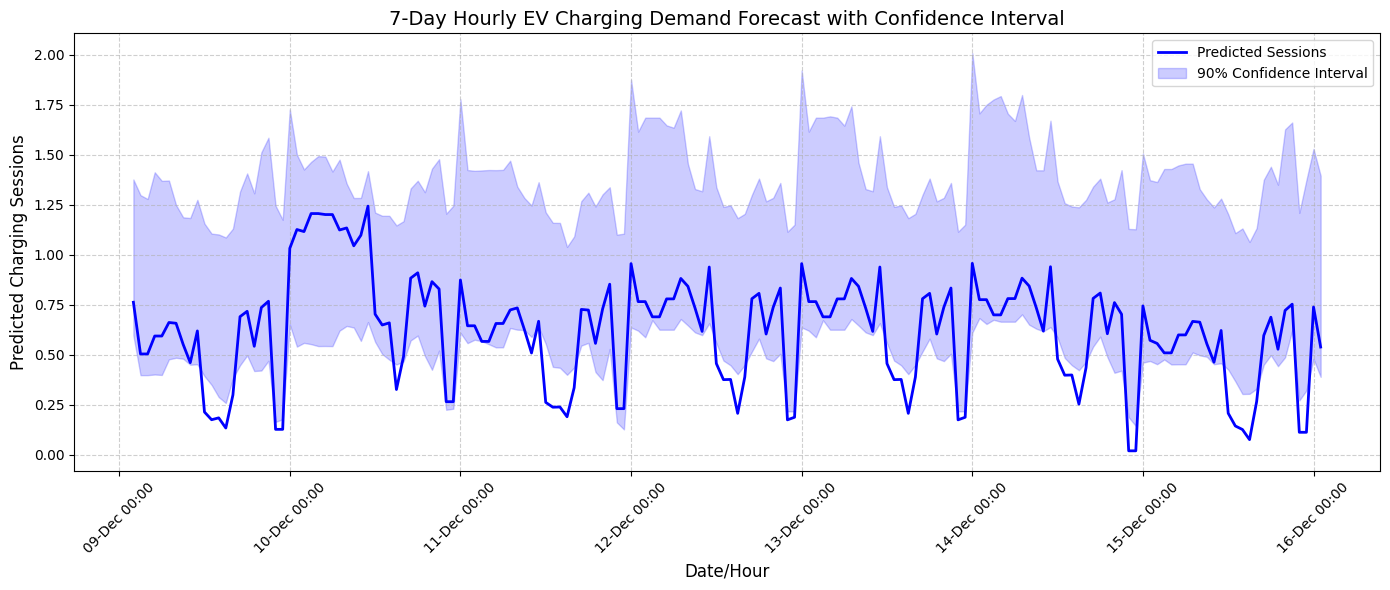

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 6))
plt.plot(future_df.index, future_df['predicted_sessions'], label='Predicted Sessions', color='blue', linewidth=2)
plt.fill_between(future_df.index, future_df['pred_lower'], future_df['pred_upper'], color='blue', alpha=0.2, label='90% Confidence Interval')

plt.xlabel('Date/Hour', fontsize=12)
plt.ylabel('Predicted Charging Sessions', fontsize=12)
plt.title('7-Day Hourly EV Charging Demand Forecast with Confidence Interval', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Format x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

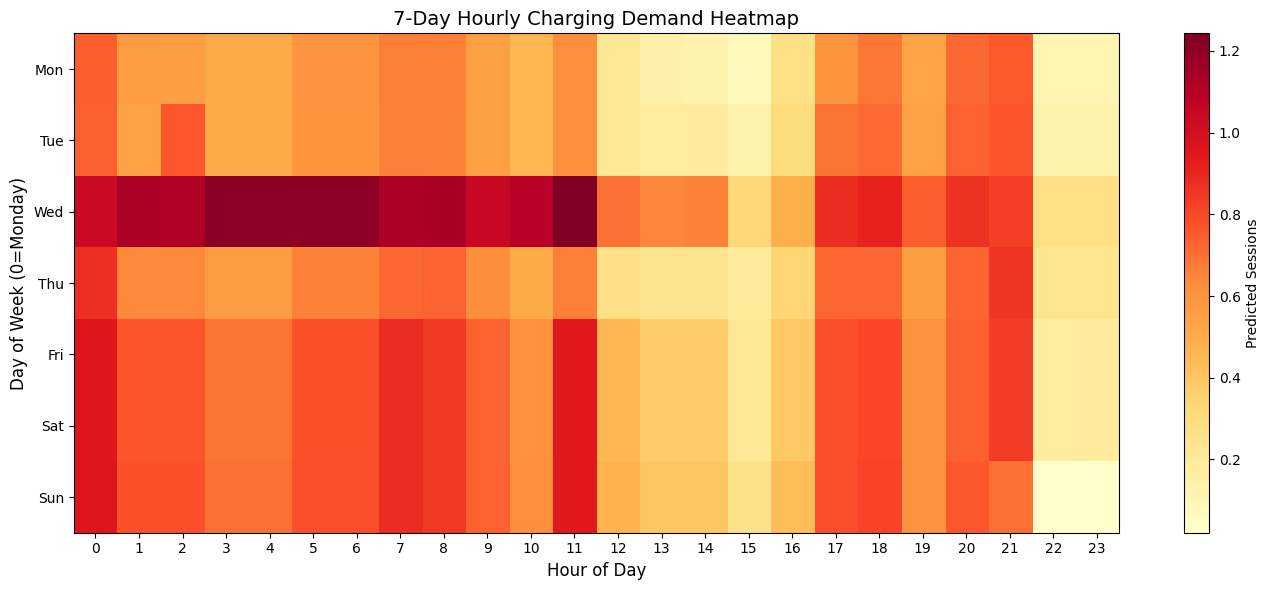

In [13]:
# Prepare data for heatmap
future_df['day_of_week'] = future_df.index.dayofweek  # 0=Monday, 6=Sunday
future_df['hour'] = future_df.index.hour

# Pivot table: days vs hours
heatmap_data = future_df.pivot_table(
    index='day_of_week', 
    columns='hour', 
    values='predicted_sessions', 
    aggfunc='mean'
)

# Plot heatmap
plt.figure(figsize=(14, 6))
plt.imshow(heatmap_data, aspect='auto', cmap='YlOrRd', interpolation='nearest')
plt.colorbar(label='Predicted Sessions')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week (0=Monday)', fontsize=12)
plt.title('7-Day Hourly Charging Demand Heatmap', fontsize=14)
plt.xticks(range(24), range(24))
plt.yticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.tight_layout()
plt.show()

In [14]:
model_poisson = xgb.XGBRegressor(
    objective='count:poisson',
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)

model_poisson.fit(X_train_encoded, y_train)
y_pred_poisson = model_poisson.predict(X_test_encoded)

# Round predictions to nearest integer
y_pred_int = np.round(y_pred_poisson).astype(int)
print("Predicted values (rounded):", np.unique(y_pred_int, return_counts=True))

Predicted values (rounded): (array([0, 1, 2]), array([ 47, 113,   8]))


In [15]:
future_df['predicted_sessions_int'] = np.round(future_df['predicted_sessions']).astype(int)
print(future_df[['predicted_sessions', 'predicted_sessions_int']].head(20))

                     predicted_sessions  predicted_sessions_int
2025-12-09 02:00:00            0.762858                       1
2025-12-09 03:00:00            0.504555                       1
2025-12-09 04:00:00            0.504555                       1
2025-12-09 05:00:00            0.594197                       1
2025-12-09 06:00:00            0.594197                       1
2025-12-09 07:00:00            0.661769                       1
2025-12-09 08:00:00            0.657973                       1
2025-12-09 09:00:00            0.552377                       1
2025-12-09 10:00:00            0.461068                       0
2025-12-09 11:00:00            0.619652                       1
2025-12-09 12:00:00            0.214513                       0
2025-12-09 13:00:00            0.176064                       0
2025-12-09 14:00:00            0.185338                       0
2025-12-09 15:00:00            0.134600                       0
2025-12-09 16:00:00            0.299786 

In [16]:
# num_sessions ko integer mein rakhna
df['num_sessions'] = df['num_sessions'].astype(int)

# Check unique values
print(df['num_sessions'].value_counts().sort_index())

num_sessions
0    311
1    257
2    106
3     47
Name: count, dtype: int64


In [17]:
from xgboost import XGBClassifier

# Target ko classification ke liye tayyar karo
y_train_cls = y_train.astype(int)
y_test_cls = y_test.astype(int)

# Model
model_cls = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    objective='multi:softprob',  # Multi-class classification
    num_class=4  # 0,1,2,3
)

model_cls.fit(X_train_encoded, y_train_cls)

# Predict probabilities
y_pred_proba = model_cls.predict_proba(X_test_encoded)
y_pred_class = model_cls.predict(X_test_encoded)

print("Predicted classes distribution:", np.unique(y_pred_class, return_counts=True))

Predicted classes distribution: (array([0, 1, 2, 3]), array([79, 70, 18,  1]))


In [18]:
# Recursive forecasting with classification
predictions_cls = []
probabilities = []

for i in range(len(future_encoded)):
    # Same lag update logic
    if i == 0:
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_1h')] = float(df['num_sessions'].iloc[-1])
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_3h')] = float(df['num_sessions'].iloc[-3] if len(df) >= 3 else 0.0)
    elif i == 1:
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_1h')] = float(predictions_cls[0])
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_3h')] = float(df['num_sessions'].iloc[-2])
    elif i == 2:
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_1h')] = float(predictions_cls[1])
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_3h')] = float(df['num_sessions'].iloc[-1])
    else:
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_1h')] = float(predictions_cls[i-1])
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_3h')] = float(predictions_cls[i-3])
    
    # Class prediction
    pred_proba = model_cls.predict_proba(future_encoded.iloc[[i]])[0]
    pred_class = model_cls.predict(future_encoded.iloc[[i]])[0]
    
    predictions_cls.append(pred_class)
    probabilities.append(pred_proba)

future_df['predicted_sessions_class'] = predictions_cls
print(future_df[['predicted_sessions_class']].head(20))

                     predicted_sessions_class
2025-12-09 02:00:00                         1
2025-12-09 03:00:00                         1
2025-12-09 04:00:00                         1
2025-12-09 05:00:00                         1
2025-12-09 06:00:00                         1
2025-12-09 07:00:00                         1
2025-12-09 08:00:00                         1
2025-12-09 09:00:00                         1
2025-12-09 10:00:00                         1
2025-12-09 11:00:00                         1
2025-12-09 12:00:00                         1
2025-12-09 13:00:00                         1
2025-12-09 14:00:00                         1
2025-12-09 15:00:00                         0
2025-12-09 16:00:00                         1
2025-12-09 17:00:00                         1
2025-12-09 18:00:00                         1
2025-12-09 19:00:00                         0
2025-12-09 20:00:00                         1
2025-12-09 21:00:00                         1


In [19]:
print("Training data distribution:")
print(y_train_cls.value_counts().sort_index())

Training data distribution:
num_sessions
0    236
1    201
2     81
3     35
Name: count, dtype: int64


In [20]:
from sklearn.utils.class_weight import compute_sample_weight

# Calculate class weights
class_weights = compute_sample_weight('balanced', y_train_cls)

# XGBoost with sample_weight
model_cls_weighted = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    objective='multi:softprob',
    num_class=4
)

model_cls_weighted.fit(X_train_encoded, y_train_cls, sample_weight=class_weights)

# Check predictions on test set
y_pred_weighted = model_cls_weighted.predict(X_test_encoded)
print("Weighted model predictions:", np.unique(y_pred_weighted, return_counts=True))

Weighted model predictions: (array([0, 1, 2, 3]), array([57, 61, 31, 19]))


In [21]:
# Recursive forecasting with weighted classification model
predictions_weighted = []

for i in range(len(future_encoded)):
    # Lag update logic (same as before)
    if i == 0:
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_1h')] = float(df['num_sessions'].iloc[-1])
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_3h')] = float(df['num_sessions'].iloc[-3] if len(df) >= 3 else 0.0)
    elif i == 1:
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_1h')] = float(predictions_weighted[0])
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_3h')] = float(df['num_sessions'].iloc[-2])
    elif i == 2:
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_1h')] = float(predictions_weighted[1])
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_3h')] = float(df['num_sessions'].iloc[-1])
    else:
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_1h')] = float(predictions_weighted[i-1])
        future_encoded.iloc[i, future_encoded.columns.get_loc('lag_3h')] = float(predictions_weighted[i-3])
    
    # Predict class with weighted model
    pred_class = model_cls_weighted.predict(future_encoded.iloc[[i]])[0]
    predictions_weighted.append(pred_class)

future_df['predicted_sessions_weighted'] = predictions_weighted
print(future_df[['predicted_sessions_weighted']].head(30))

                     predicted_sessions_weighted
2025-12-09 02:00:00                            1
2025-12-09 03:00:00                            1
2025-12-09 04:00:00                            1
2025-12-09 05:00:00                            1
2025-12-09 06:00:00                            1
2025-12-09 07:00:00                            1
2025-12-09 08:00:00                            1
2025-12-09 09:00:00                            1
2025-12-09 10:00:00                            1
2025-12-09 11:00:00                            1
2025-12-09 12:00:00                            1
2025-12-09 13:00:00                            1
2025-12-09 14:00:00                            1
2025-12-09 15:00:00                            0
2025-12-09 16:00:00                            0
2025-12-09 17:00:00                            1
2025-12-09 18:00:00                            2
2025-12-09 19:00:00                            0
2025-12-09 20:00:00                            1
2025-12-09 21:00:00 

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

# Test set predictions with weighted model
y_test_pred = model_cls_weighted.predict(X_test_encoded)

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_cls, y_test_pred))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_cls, y_test_pred))

# Actual vs Predicted distribution
print("\nActual distribution in test set:")
print(pd.Series(y_test_cls).value_counts().sort_index())
print("\nPredicted distribution in test set:")
print(pd.Series(y_test_pred).value_counts().sort_index())

Confusion Matrix:
[[29 28 10  8]
 [17 20 13  6]
 [ 8  8  6  3]
 [ 3  5  2  2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.39      0.44        75
           1       0.33      0.36      0.34        56
           2       0.19      0.24      0.21        25
           3       0.11      0.17      0.13        12

    accuracy                           0.34       168
   macro avg       0.28      0.29      0.28       168
weighted avg       0.37      0.34      0.35       168


Actual distribution in test set:
num_sessions
0    75
1    56
2    25
3    12
Name: count, dtype: int64

Predicted distribution in test set:
0    57
1    61
2    31
3    19
Name: count, dtype: int64
